In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cell Tracking Program


## 0. Prepare Import File and Import Image Set

In [2]:
!mkdir '/content/salamm'

mkdir: cannot create directory ‘/content/salamm’: File exists


In [3]:
!cp "/content/drive/MyDrive/11_01_23/raw_image.tif" "/content/salamm"

In [4]:
!mkdir '/content/salamm/gray_images'

mkdir: cannot create directory ‘/content/salamm/gray_images’: File exists


In [30]:
!mkdir '/content/salamm/mask'

In [31]:
!cp "/content/drive/MyDrive/11_01_23/annotation_Salam_JT_110123.tif" "/content/salamm/"

In [33]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/annotation_Salam_JT_110123.tif")   #/content/salam/image.tif   #/content/salamm/raw_image.tif      #/content/drive/MyDrive/11_01_23/annotation_Salam_JT_110123.tif    #/content/salamm/annotation_Salam_JT_110123.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/mask/Page%02d.tif" % i)   

In [34]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/raw_image.tif")   #/content/salam/image.tif   #/content/salamm/raw_image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/gray_images/Page%02d.tif" % i)    

In [35]:
%matplotlib inline

import os
import cv2
import PIL.Image
import sys
import numpy as np
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt
import scipy

def normalize(image):
    '''
    This function is to normalize the input grayscale image by
    substracting globle mean and dividing standard diviation for
    visualization. 

    Input:  a grayscale image

    Output: normolized grascale image

    '''
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    return image

# read image sequence
path = "/content/salamm/gray_images" # The dataset could be download through: http://www.codesolorzano.com/Challenges/CTC/Datasets.html
for r,d,f in os.walk(path):
    images = []
    enhance_images = []
    f = sorted(f)
    for files in f:
        if files[-3:].lower()=='tif':
            temp = cv2.imread(os.path.join(r,files))
            gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            images.append(gray.copy())
            enhance_images.append(normalize(gray.copy()))

print("Total number of image is ", len(images))
print("The shape of image is ", images[0].shape, type(images[0][0,0]))

Total number of image is  80
The shape of image is  (700, 1200) <class 'numpy.uint8'>


In [7]:
# Helper functions
def display_image(img):
    assert img.ndim == 2 or img.ndim == 3
    h, w = img.shape[:2]
    if len(img.shape) == 3:
        img = cv2.resize(img, (w/3, h/3, 3))
    else:
        img = cv2.resize(img, (w/3, h/3))
    cv2.imwrite("/content/salamm/temp_img.png", img)
    img = Image("/content/salamm/temp_img.png")
    display(img)

def vis_square(data, title=None):
    """
    Take an array of shape (n, height, width) or (n, height, width, 3)
    and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    """
    # resize image into small size
    _, h, w = data.shape[:3] 
    width = int(np.ceil(1200. / np.sqrt(data.shape[0])))    # the width of showing image 
    height = int(np.ceil(h*float(width)/float(w))) # the height of showing image 
    if len(data.shape) == 4:
        temp = np.zeros((data.shape[0], height, width, 3))
    else:
        temp = np.zeros((data.shape[0], height, width))
    
    for i in range(data.shape[0]):
        if len(data.shape) == 4:
            temp[i] = cv2.resize(data[i], (width, height, 3))
        else:
            temp[i] = cv2.resize(data[i], (width, height))
    
    data = temp
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
              (0, 2), (0, 2))                 # add some space between filters
              + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=255)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    # show image
    cv2.imwrite("/content/salamm/temp_img.png", data)
    img = Image("/content/salamm/temp_img.png")
    display(img)

def cvt_npimg(images):
    """
    Convert image sequence to numpy array
    """
    h, w = images[0].shape[:2]
    if len(images[0].shape) == 3:
        out = np.zeros((len(images), h, w, 3))
    else:
        out = np.zeros((len(images), h, w))
    for i, img in enumerate(images):
        out[i] = img
    return out

In [8]:
# Write image from different input
def write_mask16(images, name, index=-1):
    """
    Write image as 16 bits image
    """
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint16))
            elif i >= 10 and i < 100:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint16))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint16))
    else:
        if index < 10:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint16))
        elif index >= 10 and index < 100:
            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint16))
        else:
            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint16))   

def write_mask8(images, name, index=-1):
    """
    Write image as 8 bits image
    """
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint8))
            elif i >= 10 and i < 100:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint8))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint8))
    else:
        if index < 10:
            cv2.imwrite(name+"000"+str(index)+".tif", images.astype(np.uint8))
        elif index >= 10 and index < 100:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint8))
        elif index >= 100 and index < 1000:
            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint8)) 
        elif index >= 1000 and index < 10000:
            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint8)) 
        else:
            raise

def write_pair8(images, name, index=-1):
    """
    Write image as 8 bits image with dilation
    """
    for i, img in enumerate(images):    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        img = cv2.dilate((img*255).astype(np.uint8),kernel,iterations = 3)
        if i < 10:
            cv2.imwrite(name+"00"+str(i)+".tif", img)
        elif i >= 10 and i < 100:
            cv2.imwrite(name+"0"+str(i)+".tif", img)
        else:
            cv2.imwrite(name+str(i)+".tif", img)

In [9]:
'''
# Write image from different input
def write_mask16(images, name, index=-1):
    """
    Write image as 16 bits image
    """
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint16))
            elif i >= 10 and i < 80:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint16))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint16))
    else:
        if index < 10:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint16))
        elif index >= 10 and index < 80:
            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint16))
        else:
            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint16))   

def write_mask8(images, name, index=-1):
    """
    Write image as 8 bits image
    """
    if index == -1:
        for i, img in enumerate(images):
            if i < 10:
                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint8))
            elif i >= 10 and i < 80:
                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint8))
            else:
                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint8))
    else:
        if index < 10:
            cv2.imwrite(name+"000"+str(index)+".tif", images.astype(np.uint8))
        elif index >= 10 and index < 80:
            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint8))
        #elif index >= 100 and index < 1000:
            #cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint8)) 
        #elif index >= 1000 and index < 10000:
            #cv2.imwrite(name+str(index)+".tif", images.astype(np.uint8)) 
        else:
            raise

def write_pair8(images, name, index=-1):
    """
    Write image as 8 bits image with dilation
    """
    for i, img in enumerate(images):    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
        img = cv2.dilate((img*255).astype(np.uint8),kernel,iterations = 3)
        if i < 10:
            cv2.imwrite(name+"00"+str(i)+".tif", img)
        elif i >= 10 and i < 80:
            cv2.imwrite(name+"0"+str(i)+".tif", img)
        else:
            cv2.imwrite(name+str(i)+".tif", img)
'''            

'\n# Write image from different input\ndef write_mask16(images, name, index=-1):\n    """\n    Write image as 16 bits image\n    """\n    if index == -1:\n        for i, img in enumerate(images):\n            if i < 10:\n                cv2.imwrite(name+"00"+str(i)+".tif", img.astype(np.uint16))\n            elif i >= 10 and i < 80:\n                cv2.imwrite(name+"0"+str(i)+".tif", img.astype(np.uint16))\n            else:\n                cv2.imwrite(name+str(i)+".tif", img.astype(np.uint16))\n    else:\n        if index < 10:\n            cv2.imwrite(name+"00"+str(index)+".tif", images.astype(np.uint16))\n        elif index >= 10 and index < 80:\n            cv2.imwrite(name+"0"+str(index)+".tif", images.astype(np.uint16))\n        else:\n            cv2.imwrite(name+str(index)+".tif", images.astype(np.uint16))   \n\ndef write_mask8(images, name, index=-1):\n    """\n    Write image as 8 bits image\n    """\n    if index == -1:\n        for i, img in enumerate(images):\n          

## 1. Cell Segmentatioin Part
<br>
<MTMarkdownOptions output='html4'>
    1. Adaptive Thresholding
    <br>
    This file is to compute adaptive thresholding of image sequence in 
    order to generate binary image for Nuclei segmentation.

    Problem:
    Due to the low contrast of original image, the adaptive thresholding is not working. 
    Therefore, we change to regular threshold with threshold value as 129.
</MTMarkdownOptions>


In [10]:
th = None
img = None

class ADPTIVETHRESH():
    '''
    This class is to provide all function for adaptive thresholding.

    '''
    def __init__(self, images):
        self.images = []
        for img in images:
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.images.append(img.copy())

    def applythresh(self, threshold = 50):
        '''
        applythresh function is to convert original image to binary image by thresholding.

        Input: image sequence. E.g. [image0, image1, ...]

        Output: image sequence after thresholding. E.g. [image0, image1, ...]
        '''
        out = []
        markers = []
        binarymark = []

        for img in self.images:
            img = cv2.GaussianBlur(img,(5,5),0).astype(np.uint8)
            _, thresh = cv2.threshold(img,threshold,1,cv2.THRESH_BINARY)

            # Using morphlogical operations to imporve the quality of result
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            out.append(thresh)

        return out

In [11]:
!mkdir '/content/salamm/temp'

mkdir: cannot create directory ‘/content/salamm/temp’: File exists


In [12]:
# This part is for testing adaptivethresh.py with single image.
# Input: an original image
# Output: Thresholding image

global th
global img

adaptive = ADPTIVETHRESH(enhance_images)
th = adaptive.applythresh(50)

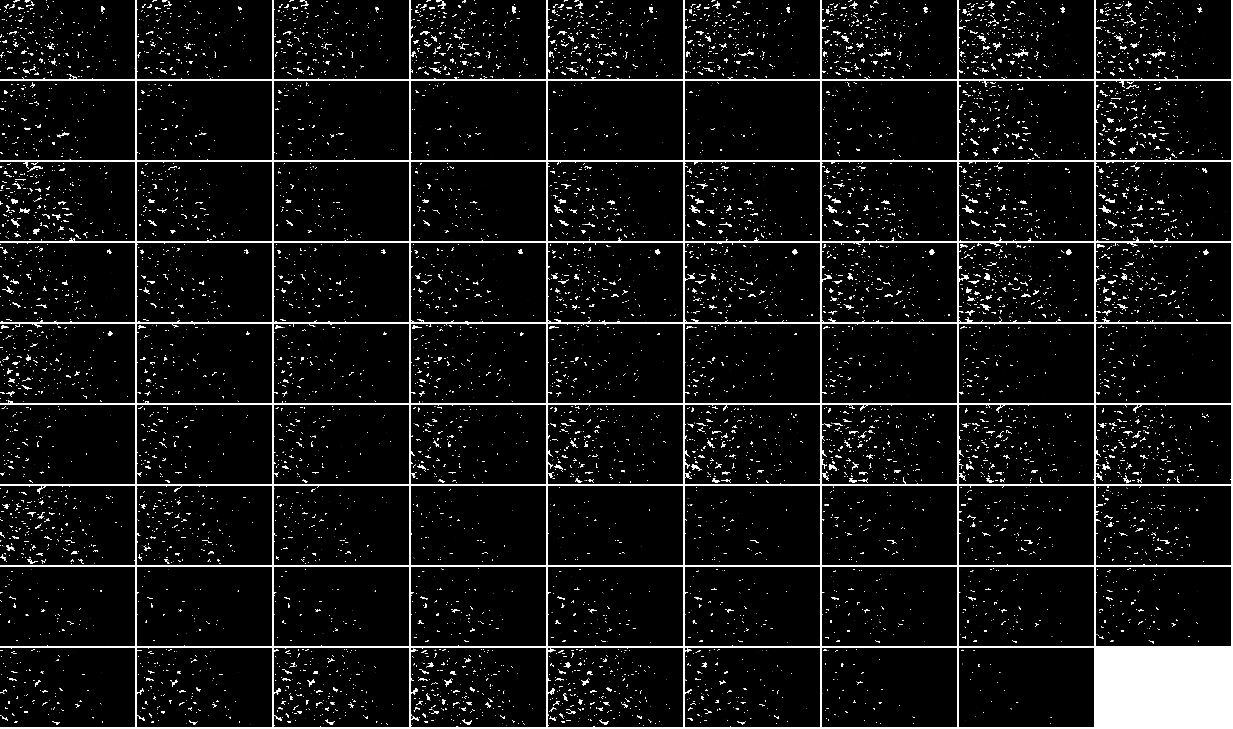

In [13]:
# display images
for i,img in enumerate(th):
    th[i] = img*255
os.chdir("/content/salamm/temp")
write_mask16(th, "thresh")
out = cvt_npimg(th)
vis_square(out)

<br>
<MTMarkdownOptions output='html4'>
    2. Gradient Filed Vector*
    <br>
    This file is to compute gradient vector field (GVF) and then find the Nuclei center 
    with the GVF result. (This part is optinal and I recommend using the distance map directly)
</MTMarkdownOptions>

In [16]:
from scipy import spatial as sp
from scipy import ndimage
from scipy.spatial import distance

looplimit = 500

newimg = None
pair = None

def inbounds(shape, indices):
    assert len(shape) == len(indices)
    for i, ind in enumerate(indices):
        if ind < 0 or ind >= shape[i]:
            return False
    return True

class GVF():
    '''
    This class contains all function for calculating GVF and its following steps.
    
    '''
    def __init__(self, images, thresh):
        
        self.images = images
        self.thresh = thresh

    def distancemap(self):
        '''
        This function is to generate distance map of the thresh image. We use the opencv
        function distanceTransform to generate it. Moreover, in this case, we use Euclidiean
        Distance (DIST_L2) as a metric of distance. 

        Input: None

        Output: Image distance map

        '''
        return [cv2.distanceTransform(self.thresh[i], distanceType=2, maskSize=0)\
                for i in range(len(self.thresh))]

    def new_image(self, alpha, dismap):
        '''
        This function is to generate a new image combining the oringal image I0 with
        the distance map image Idis by following expression:
                                Inew = I0 + alpha*Idis
        In this program, we choose alpha as 0.4.

        Input: the weight of distance map: alpha
               the distance map image

        Output: new grayscale image

        '''

        return [self.images[i] + alpha * dismap[i] for i in range(len(self.thresh))]          #x=np.array ([x0,]*n)

    def compute_gvf(self, newimage):
        '''
        This function is to compute the gradient vector of the imput image.

        Input: a grayscale image with size, say m * n * # of images

        Output: a 3 dimentional image with size, m * n * 2, where the last dimention is
        the gradient vector (gx, gy)

        '''
        kernel_size = 5 # kernel size for blur image before compute gradient
        newimage = [cv2.GaussianBlur((np.clip(newimage[i], 0, 255)).astype(np.uint8),(kernel_size,kernel_size),0)\
                    for i in range(len(self.thresh))]
        # use sobel operator to compute gradient 
        temp = np.zeros((newimage[0].shape[0], newimage[0].shape[1], 2), np.float32) # store temp gradient image 
        gradimg = []  # output gradient images (height * weight * # of images)

        for i in range(len(newimage)):
            # compute sobel operation in x, y directions
            gradx = cv2.Sobel(newimage[i],cv2.CV_64F,1,0,ksize=3)
            grady = cv2.Sobel(newimage[i],cv2.CV_64F,0,1,ksize=3)
            # add the gradient vector
            temp[:,:,0], temp[:,:,1] = gradx, grady
            gradimg.append(temp)

        return gradimg

    def find_certer(self, gvfimage, index):
        '''
        This function is to find the center of Nuclei.

        Input: the gradient vector image (height * weight * 2).

        Output: the record image height * weight).

        '''
        # Initialize a image to record seed candidates.
        imgpair = np.zeros(gvfimage.shape[:2])

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        dilate = cv2.dilate(self.thresh[index].copy(), kernel, iterations = 1)
        erthresh = cv2.erode(dilate, kernel, iterations = 3)
        while erthresh.sum() > 0:

            print("Image ", index, "left: ", erthresh.sum(), "points")
            # Initialize partical coordinates [y, x]
            y0, x0 = np.where(erthresh>0)
            p0 = np.array([y0[0], x0[0], 1])

            # Initialize record coordicates [y, x]
            p1 = np.array([5000, 5000, 1])

            # mark the first non-zero point of thresh image to 0
            erthresh[p0[0], p0[1]] = 0

            # a variable to record if the point out of bound of image or 
            # out of maximum loop times
            outbound = False

            # count loop times to limit max loop times
            count = 0

            while sp.distance.cdist([p0],[p1]) > 1:

                count += 1
                p1 = p0
                u = gvfimage[p0[0], p0[1], 1]
                v = gvfimage[p0[0], p0[1], 0]
                M = np.array([[1, 0, u],\
                              [0, 1, v],\
                              [0, 0, 1]], np.float32)
                p0 = M.dot(p0)
                if not inbounds(self.thresh[index].shape, (p0[0], p0[1])) or count > looplimit:
                    outbound = True
                    break

            if not outbound:
                imgpair[p0[0], p0[1]] += 1
            clear_output(wait=True)

        return imgpair.copy()

In [17]:
'''
# This part is for testing gvf.py with single image. (Optional)
# Input: an original image
# Output: Thresholding image and seed image

global th
global newimg
global pair
# Nuclei center detection
gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
gradimg = gvf.compute_gvf(newimg)
out = []
pair = []
pair_raw = []
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
i = 0
for i,img in enumerate(gradimg):
    imgpair_raw = gvf.find_certer(img, i)
    pair_raw.append(imgpair_raw)
    neighborhood_size = 20
    data_max = ndimage.filters.maximum_filter(pair_raw[i], neighborhood_size)
    data_max[data_max==0] = 255
    pair.append((pair_raw[i] == data_max).astype(np.uint8))
    write_mask8([pair[i]], "pair_raw", i)
    os.chdir("PATH_TO_RESULTS")
    y, x = np.where(pair[i]>0)
    points = zip(y[:], x[:])
    dmap = distance.cdist(points, points, 'euclidean')
    y, x = np.where(dmap<10)
    ps = zip(y[:], x[:])
    for p in ps:
        if p[0] != p[1]:
            pair[i][points[min(p[0], p[1])]] = 0
    dilation = cv2.dilate((pair[i]*255).astype(np.uint8),kernel,iterations = 3)
    out.append(dilation)

out = cvt_npimg(out)
vis_square(out)
'''

'\n# This part is for testing gvf.py with single image. (Optional)\n# Input: an original image\n# Output: Thresholding image and seed image\n\nglobal th\nglobal newimg\nglobal pair\n# Nuclei center detection\ngvf = GVF(images, th)\ndismap = gvf.distancemap()\nnewimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.\ngradimg = gvf.compute_gvf(newimg)\nout = []\npair = []\npair_raw = []\nkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))\ni = 0\nfor i,img in enumerate(gradimg):\n    imgpair_raw = gvf.find_certer(img, i)\n    pair_raw.append(imgpair_raw)\n    neighborhood_size = 20\n    data_max = ndimage.filters.maximum_filter(pair_raw[i], neighborhood_size)\n    data_max[data_max==0] = 255\n    pair.append((pair_raw[i] == data_max).astype(np.uint8))\n    write_mask8([pair[i]], "pair_raw", i)\n    os.chdir("PATH_TO_RESULTS")\n    y, x = np.where(pair[i]>0)\n    points = zip(y[:], x[:])\n    dmap = distance.cdist(points, points, \'euclidean\')\n    y, x = np.where(dmap<10)\n   

<br>
<MTMarkdownOptions output='html4'>
    GVF enhance*
    <br>
    This file is to amend the seed points for watershed. (This part is optinal and I recommend using the distance map directly)
</MTMarkdownOptions>

In [18]:
!mkdir '/content/salamm/pair_raw'

mkdir: cannot create directory ‘/content/salamm/pair_raw’: File exists


In [19]:
'''
# This part is for testing gvf.py with single image. (Optional)
# Input: an original image
# Output: Thresholding image and seed image

global th
global newimg
global pair
# Nuclei center detection
gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
gradimg = gvf.compute_gvf(newimg)
out = []
pair = []
pair_raw = []
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
i = 0
for i,img in enumerate(gradimg):
    imgpair_raw = gvf.find_certer(img, i)
    pair_raw.append(imgpair_raw)
    neighborhood_size = 20
    data_max = ndimage.filters.maximum_filter(pair_raw[i], neighborhood_size)
    data_max[data_max==0] = 255
    pair.append((pair_raw[i] == data_max).astype(np.uint8))
    write_mask8([pair[i]], "pair_raw", i)
    os.chdir("/content/salamm/pair_raw")
    y, x = np.where(pair[i]>0)
    #points = zip(y[:], x[:])
    points = np.vstack((y, x)).T
    dmap = distance.cdist(points, points, 'euclidean')
    y, x = np.where(dmap<10)
    ps = zip(y[:], x[:])
    for p in ps:
        if p[0] != p[1]:
            pair[i][points[min(p[0], p[1])]] = 0
    dilation = cv2.dilate((pair[i]*255).astype(np.uint8),kernel,iterations = 3)
    out.append(dilation)

out = cvt_npimg(out)
vis_square(out)
'''

'\n# This part is for testing gvf.py with single image. (Optional)\n# Input: an original image\n# Output: Thresholding image and seed image\n\nglobal th\nglobal newimg\nglobal pair\n# Nuclei center detection\ngvf = GVF(images, th)\ndismap = gvf.distancemap()\nnewimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.\ngradimg = gvf.compute_gvf(newimg)\nout = []\npair = []\npair_raw = []\nkernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))\ni = 0\nfor i,img in enumerate(gradimg):\n    imgpair_raw = gvf.find_certer(img, i)\n    pair_raw.append(imgpair_raw)\n    neighborhood_size = 20\n    data_max = ndimage.filters.maximum_filter(pair_raw[i], neighborhood_size)\n    data_max[data_max==0] = 255\n    pair.append((pair_raw[i] == data_max).astype(np.uint8))\n    write_mask8([pair[i]], "pair_raw", i)\n    os.chdir("/content/salamm/pair_raw")\n    y, x = np.where(pair[i]>0)\n    #points = zip(y[:], x[:])\n    points = np.vstack((y, x)).T\n    dmap = distance.cdist(points, points, \'euc

In [20]:
from scipy import spatial as sp
from scipy import ndimage
from scipy.spatial import distance

gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
# TODO this part is designed to amend the result of gvf. 
pair = []
path=os.path.join("/content/salamm/temp")
for r,d,f in os.walk(path):
    for files in f:
        if files[:5].lower()=='seed':
            print(files)
            temp = cv2.imread(os.path.join(r,files))
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            y, x = np.where(temp>0)
            points = zip(y[:], x[:])
            dmap = distance.cdist(points, points, 'euclidean')
            y, x = np.where(dmap<10)
            ps = zip(y[:], x[:])
            for p in ps:
                if p[0] != p[1]:
                    temp[points[min(p[0], p[1])]] = 0
            pair.append(temp)
            clear_output(wait=True)
print("finish!")

finish!


<br>
<MTMarkdownOptions output='html4'>
    2. Distance Map (Recommend)
    <br>
    This file uses distance map to generate the seed points for watershed. Although it has nothing to do with GVF, you still need to load the GVF class, since it needs some helper functions in the class.
</MTMarkdownOptions>

In [21]:
!mkdir '/content/salamm/pair_result'

mkdir: cannot create directory ‘/content/salamm/pair_result’: File exists


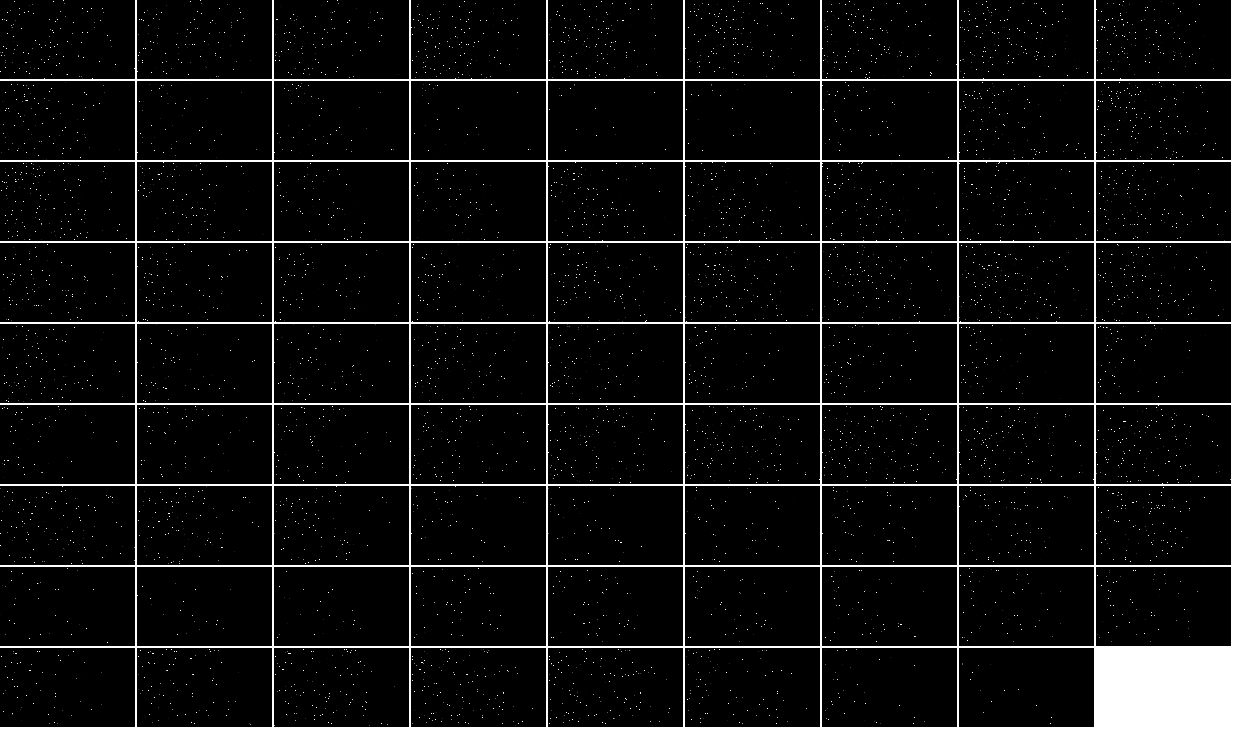

In [22]:
from scipy.spatial import distance
gvf = GVF(images, th)
dismap = gvf.distancemap()
newimg = gvf.new_image(0.4, dismap) # choose alpha as 0.4.
out = []
pair = []
#i = 0
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
for i,img in enumerate(dismap):
    neighborhood_size = 20
    data_max = ndimage.filters.maximum_filter(img, neighborhood_size)
    data_max[data_max==0] = 255
    pair.append((img == data_max).astype(np.uint8))
    y, x = np.where(pair[i]>0)
    #print(pair[i])
    #points = zip(y[:], x[:])    #points = np.vstack((y, x)).T
    points = np.vstack((y, x)).T        #np.vstack(map(np.ravel, g))
    dmap = distance.cdist(points, points, 'euclidean')
    #dmap = distance.euclidean(points, points)   #distances = sp.spatial.distance.cdist(source_matrix, target_matrix)
    y, x = np.where(dmap<20)     
    ps = np.vstack((y, x)).T       #zip(y[:], x[:])      #np.vstack((y, x)).T         #ps = zip(y[:], x[:])
    #for p in ps:
    #    if p[0] != p[1]:
    #        pair[i][points[min(p[0], p[1])]] = 0       #x=np.array ([x0,]*n)
    dilation = cv2.dilate((pair[i]*255).astype(np.uint8),kernel,iterations = 1)
    out.append(dilation)
    os.chdir("/content/salamm/pair_result")
    write_mask8(dilation, "seed_point", i)

out = cvt_npimg(out)
vis_square(out)

<br>
<MTMarkdownOptions output='html4'>
    3. Watershed
    <br>
    This file is to compute watershed given the seed image in the gvf.py.
</MTMarkdownOptions>

In [23]:
import cv2
import numpy as np
from numpy import unique
import copy as cp

bmarks = None
marks = None

class WATERSHED():
    '''
    This class contains all the function to compute watershed.

    '''
    def __init__(self, images, markers):
        self.images = images
        self.markers = markers

    def is_over_long(self, img, max_lenth=50):
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        if not len(img[img>0]):
            return True
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        if (rmax-rmin)>max_lenth or (cmax-cmin)>max_lenth:
            return True
        else:
            return False
    
    def watershed_compute(self):
        '''
        This function is to compute watershed given the newimage and the seed image
        (center candidates). In this function, we use cv2.watershed to implement watershed.

        Input: newimage (height * weight * # of images)

        Output: watershed images (height * weight * # of images)

        '''
        result = []
        outmark = []
        outbinary = []

        for i in range(len(self.images)):
            print("image: ", i)
            # generate a 3-channel image in order to use cv2.watershed
            imgcolor = np.zeros((self.images[i].shape[0], self.images[i].shape[1], 3), np.uint8)
            for c in range(3): 
                imgcolor[:,:,c] = self.images[i]

            # compute marker image (labelling)
            if len(self.markers[i].shape) == 3:
                self.markers[i] = cv2.cvtColor(self.markers[i],cv2.COLOR_BGR2GRAY)
            _, mark = cv2.connectedComponents(self.markers[i])
            
            # watershed!
            mark = cv2.watershed(imgcolor,mark)
            
            u, counts = unique(mark, return_counts=True)
            counter = dict(zip(u, counts))
            for index in counter:
                temp_img = np.zeros_like(mark)
                temp_img[mark==index] = 255
                if self.is_over_long(temp_img):
                    mark[mark==index] = 0
                    continue
                if counter[index] > 3000:
                    mark[mark==index] = 0
                    continue
            
            labels = list(set(mark[mark>0]))
            length = len(labels)
            temp_img = mark.copy()
            for original, new in zip(labels, range(1,length+1)):
                temp_img[mark==original] = new
            mark = temp_img
                
            # mark image and add to the result 
            temp = cv2.cvtColor(imgcolor,cv2.COLOR_BGR2GRAY)
            result.append(temp)
            outmark.append(mark.astype(np.uint8))

            binary = mark.copy()
            binary[mark>0] = 255
            outbinary.append(binary.astype(np.uint8))
            clear_output(wait=True)

        return result, outbinary, outmark

In [24]:
!mkdir '/content/result_path'
!mkdir '/content/result_binary'

mkdir: cannot create directory ‘/content/result_path’: File exists
mkdir: cannot create directory ‘/content/result_binary’: File exists


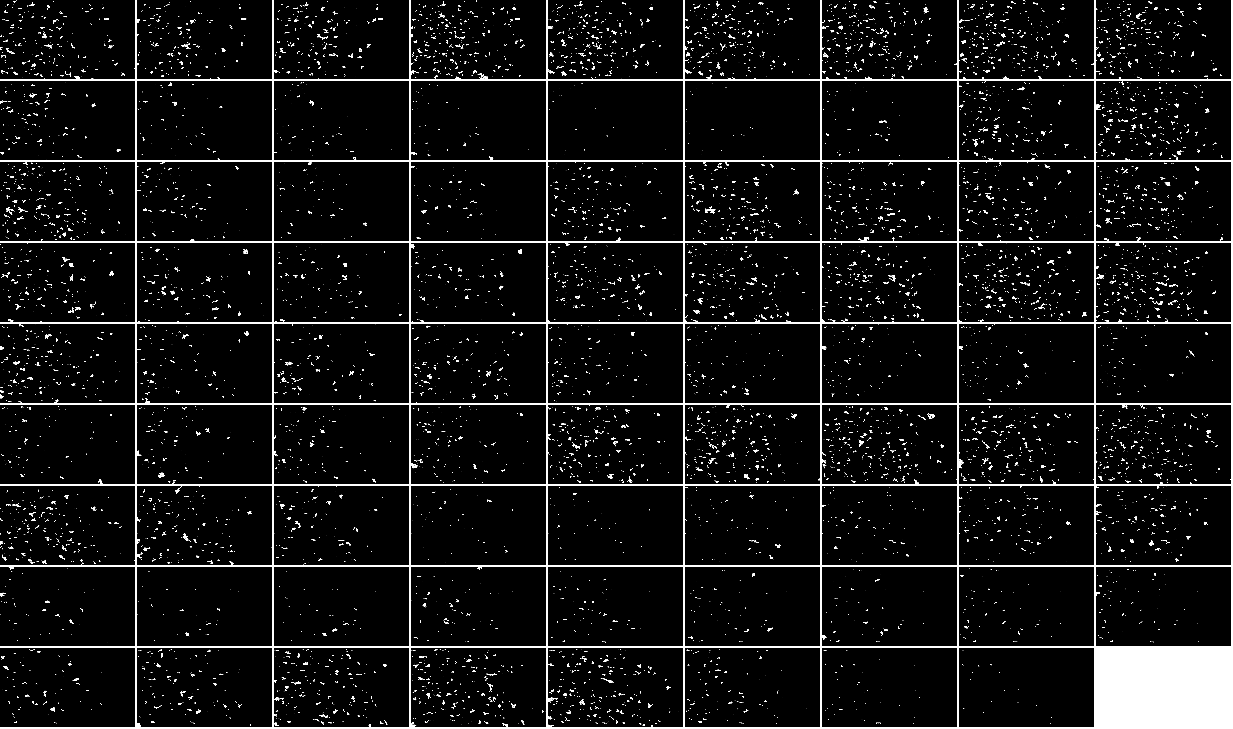

In [25]:
# This part is for testing watershed.py with single image.
# Output: Binary image after watershed

global bmarks
global marks

# watershed
ws = WATERSHED(newimg, pair) 
wsimage, bmarks, marks = ws.watershed_compute()

out = cvt_npimg(np.clip(bmarks, 0, 255)).astype(np.uint8)
vis_square(out)
os.chdir("/content/result_path")
write_mask16(marks, "mask")
os.chdir("/content/result_binary")
write_mask8(out, "binary")
clear_output(wait=True)

<MTMarkdownOptions output='html4'>
    4. Segmentation Evaluation
    <br>
    This file is to evaluate our algorithm about segmentation in jaccard coefficient.
</MTMarkdownOptions>

In [26]:
!mkdir '/content/segmentation_result'

mkdir: cannot create directory ‘/content/segmentation_result’: File exists


In [38]:
from __future__ import division
def list2pts(ptslist):
    list_y = np.array([ptslist[0]])
    list_x = np.array([ptslist[1]])
    return np.append(list_y, list_x).reshape(2, len(list_y[0])).T

def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

# read image sequence
# The training set locates at "resource/training/01" and "resource/training/02"
# The ground truth of training set locates at "resource/training/GT_01" and 
# "resource/training/GT_02"
# The testing set locates at "resource/testing/01" and "resource/testing/02"

path = "/content/salamm/gray_images"
gts = []
for r,d,f in os.walk(path):
    for files in f:
        if files[-3:].lower()=='tif':
            temp = cv2.imread(os.path.join(r,files), cv2.IMREAD_UNCHANGED)
            gts.append([temp, files[-6:-4]])
print("number of gts: ", len(gts))

path= "/content/salamm/mask"
binarymarks = []
for r,d,f in os.walk(path):
    for files in f:
        if files[:4]=='mark':
            temp = cv2.imread(os.path.join(r,files))
            gray = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY) 
            binarymarks.append([gray, files[-6:-4]])
print("number of segmentation image: ", len(binarymarks))

'''
jaccards = []

for gt in gts:
    for binarymark in binarymarks:
        if gt[1] == binarymark[1]:
            print("enter...", gt[1])
            list_pts = set(gt[0][gt[0]>0])
            list_seg = set(binarymark[0][binarymark[0]>0])
            for pt in list_pts:
                for seg in list_seg:
                    pts_gt = np.where(gt[0]==pt)
                    pts_seg = np.where(binarymark[0]==seg)
                    pts_gt = list2pts(pts_gt)

                    pts_seg = list2pts(pts_seg)
                    pts = np.append(pts_gt, pts_seg).reshape(len(pts_gt)+len(pts_seg),2)
                    union_pts = unique_rows(pts)

                    union = float(len(union_pts))
                    intersection = float(len(pts_seg) + len(pts_gt) - len(union_pts))

                    if intersection/union > 0.500:
                        jaccards.append(intersection/union)
clear_output(wait=True)
from __future__ import division
jaccard = float(sum(jaccards))/float(len(jaccards))
print("jaccard: ", jaccards, "number of Nuclei: ", len(jaccards))
'''

number of gts:  80
number of segmentation image:  0


'\njaccards = []\n\nfor gt in gts:\n    for binarymark in binarymarks:\n        if gt[1] == binarymark[1]:\n            print("enter...", gt[1])\n            list_pts = set(gt[0][gt[0]>0])\n            list_seg = set(binarymark[0][binarymark[0]>0])\n            for pt in list_pts:\n                for seg in list_seg:\n                    pts_gt = np.where(gt[0]==pt)\n                    pts_seg = np.where(binarymark[0]==seg)\n                    pts_gt = list2pts(pts_gt)\n\n                    pts_seg = list2pts(pts_seg)\n                    pts = np.append(pts_gt, pts_seg).reshape(len(pts_gt)+len(pts_seg),2)\n                    union_pts = unique_rows(pts)\n\n                    union = float(len(union_pts))\n                    intersection = float(len(pts_seg) + len(pts_gt) - len(union_pts))\n\n                    if intersection/union > 0.500:\n                        jaccards.append(intersection/union)\nclear_output(wait=True)\nfrom __future__ import division\njaccard = float(su

## 2. Cell Tracking Part
<br>
<MTMarkdownOptions output='html4'>
    1. Graph Construction
    <br>
    This file is to generate a neighboring graph contraction using 
    Delaunary Triangulation.
</MTMarkdownOptions>

In [39]:
centroid = None
slope_length = None
class GRAPH():
    '''
    This class contains all the functions needed to compute 
    Delaunary Triangulation.

    '''
    def __init__(self, mark, binary, index):
        '''
        Input: the grayscale mark image with different label on each segments
               the binary image of the mark image
               the index of the image

        '''
        self.mark = mark[index]
        self.binary = binary[index]
              
    def rect_contains(self, rect, point):
        '''
        Check if a point is inside the image

        Input: the size of the image 
               the point that want to test

        Output: if the point is inside the image

        '''
        if point[0] < rect[0] :
            return False
        elif point[1] < rect[1] :
            return False
        elif point[0] > rect[2] :
            return False
        elif point[1] > rect[3] :
            return False
        return True
     
    def draw_point(self, img, p, color ):
        '''
        Draw a point

        '''
        cv2.circle( img, (p[1], p[0]), 2, color, cv2.FILLED, 16, 0 )
     
    def draw_delaunay(self, img, subdiv, delaunay_color):
        '''
        Draw delaunay triangles and store these lines

        Input: the image want to draw
               the set of points: format as cv2.Subdiv2D
               the color want to use

        Output: the slope and length of each line ()

        '''
        triangleList = subdiv.getTriangleList();
        size = img.shape
        r = (0, 0, size[0], size[1])

        slope_length = [[]]
        for i in range(self.mark.max()-1):
            slope_length.append([])

        for t_i, t in enumerate(triangleList):
             
            pt1 = (int(t[0]), int(t[1]))
            pt2 = (int(t[2]), int(t[3]))
            pt3 = (int(t[4]), int(t[5]))
             
            if self.rect_contains(r, pt1) and self.rect_contains(r, pt2) and self.rect_contains(r, pt3):
                
                # draw lines
                cv2.line(img, (pt1[1], pt1[0]), (pt2[1], pt2[0]), delaunay_color, 1, 16, 0)
                cv2.line(img, (pt2[1], pt2[0]), (pt3[1], pt3[0]), delaunay_color, 1, 16, 0)
                cv2.line(img, (pt3[1], pt3[0]), (pt1[1], pt1[0]), delaunay_color, 1, 16, 0)
                
                # store the length of line segments and their slopes
                for p0 in [pt1, pt2, pt3]:
                    for p1 in [pt1, pt2, pt3]:
                        if p0 != p1:
                            temp = self.length_slope(p0, p1)
                            if temp not in slope_length[self.mark[p0]-1]:
                                slope_length[self.mark[p0]-1].append(temp)                

        return slope_length

    def length_slope(self, p0, p1):
        '''
        This function is to compute the length and theta for the given two points.

        Input: two points with the format (y, x)

        '''
        if p1[1]-p0[1]:
            slope = (p1[0]-p0[0]) / (p1[1]-p0[1])
        else:
            slope = 1e10

        length = np.sqrt((p1[0]-p0[0])**2 + (p1[1]-p0[1])**2)

        return length, slope

    def generate_points(self):
        '''
        Find the centroid of each segmentation

        '''
        centroids = []
        label = []
        max_label = self.mark.max()

        for i in range(1, max_label+1):
            img = self.mark.copy()
            img[img!=i] = 0
            if img.sum():
                _, contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
                m = cv2.moments(contours[0])

                if m['m00']:
                    label.append(i)
                    centroids.append(( int(round(m['m01']/m['m00'])),\
                                       int(round(m['m10']/m['m00'])) ))
                else:
                    label.append(i)
                    centroids.append(( 0,0 ))

        return centroids, label

    def run(self, animate = False):
        '''
        The pipline of graph construction.

        Input: if showing a animation (False for default)

        Output: centroids: # of segments * 2   (y, x)
                slopes and length: # of segments * # of slope_length

        '''
        # Read in the image.
        img_orig = self.binary.copy()
         
        # Rectangle to be used with Subdiv2D
        size = img_orig.shape
        rect = (0, 0, size[0], size[1])
         
        # Create an instance of Subdiv2D
        subdiv = cv2.Subdiv2D(rect);
        
        # find the centroid of each segments
        points, label = self.generate_points()


        # add and sort the centroid to a numpy array for post processing
        centroid = np.zeros((self.mark.max(), 2))
        for p, l in zip(points, label):
            centroid[l-1] = p

        outimg = []
        # Insert points into subdiv
        for idx_p, p in enumerate(points):
            subdiv.insert(p)
             
            # Show animation
            if animate:
                img_copy = img_orig.copy()
                # Draw delaunay triangles
                self.draw_delaunay( img_copy, subdiv, (255, 255, 255));
                outimg.append(img_copy)
                display_image(img_copy)
                img_copy = cv2.resize(img_copy, (314, 200))
                cv2.imwrite("delaunay_" + str(idx_p).zfill(3) + ".png", img_copy)
                clear_output(wait=True)
                
        # Draw delaunay triangles
        slope_length = self.draw_delaunay( img_orig, subdiv, (255, 255, 255));
     
        # Draw points
        for p in points :
            self.draw_point(img_orig, p, (0,0,255))
        
        # show images
        if animate:
            display_image(img_orig)

        print("length of centroid: ", len(centroid))
        return centroid, slope_length

In [40]:
# This part is the small test for graph_contruction.py.
# Input:  grayscale marker image
#         binary marker image
# Output: a text file includes the centroid and the length and slope for each neighbor. 

# Build Delaunay Triangulation
global centroid
global slope_length
centroid = []
slope_length = []
for i in range(len(images)):
    print("graph_construction: image ", i)
    print("max pixel: ", marks[i].max())
    graph = GRAPH(marks, bmarks, i)
    if i == 0:
        tempcentroid, tempslope_length = graph.run(True)
    else:
        tempcentroid, tempslope_length = graph.run()
    centroid.append(tempcentroid)
    slope_length.append(tempslope_length)
    clear_output(wait=True)
print("finish!")

graph_construction: image  0
max pixel:  231


ValueError: ignored

<MTMarkdownOptions output='html4'>
    2. Matching
    <br>
    This file is to match nuclei in two consecutive frames by Phase Controlled Optimal Matching. 
    It includes two part: 
		1) Dissimilarity measure
		2) Matching
</MTMarkdownOptions>

In [41]:
!pip install pyefd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import imageio
from pyefd import elliptic_fourier_descriptors

Max_dis = 100000

def write_image(image, title, index, imgformat='.tif'):
    if index < 10:
            name = '00'+str(index)
    else:
        name = '0'+str(index)
    cv2.imwrite(title+name+imgformat, image.astype(np.uint16))

class FEAVECTOR():
    '''
    This class builds a feature vector for each segments.
    The format of each vector is: 
                    v(k,i) = [c(k,i), s(k, i), h(k, i), e(k, i)], where k is the 
                    index of the image (frame) and i is the label of each segment. 

                    c(k,i): the centroid of each segment (y, x);
                    s(k,i): the binary shape of each segment;
                    h(k,i): the intensity distribution (hsitogram) of the segment;
                    e(k,i): the spatial distribution of the segment. Its format is 
                    like (l(k, i, p), theta(k, i, p)), where p represent different
                    line connected with different segment. 

    '''
    def __init__(self, centroid=None, shape=None, histogram=None, spatial=None, \
                       ID=None, start = None, end=None, label=None, ratio=None, area=None, cooc=None):
        self.c = centroid
        self.s = shape
        self.h = histogram
        self.e = spatial
        self.id = ID
        self.start = start
        self.end = end
        self.l = label
        self.a = area
        self.r = ratio
        self.cm = cooc

    def add_id(self, num, index):
        '''
        This function adds cell id for each cell.

        '''
        if index == 0:
            self.id = np.linspace(1, num, num)
        else:
            self.id= np.linspace(-1, -1, num)

    def add_label(self):
        '''
        This function is to add labels for each neclei for post process.

        '''
        self.l = np.linspace(0, 0, len(self.c))

    def set_centroid(self, centroid):
        '''
        This function sets the centroid for all neclei.

        Input: the set of centroid: # of images * # of neclei * 2 (y, x)

        Output: None

        '''
        self.c = centroid

    def set_spatial(self, spatial):
        '''
        This function sets the spatial distrbution for all neclei.

        Input: the set of centroid: # of images * # of neclei * # of line segments (length, slope)

        Output: None

        '''
        self.e = spatial

    def set_shape(self, image, marker):
        '''
        This function sets the binary shape for all necluei.

        Input: the original images: # of images * height * weight
               the labeled images: # of images * nucei's height * nucei's weight ()

        Output: None

        '''
        def boundingbox(image):
            y, x = np.where(image)
            return min(x), min(y), max(x), max(y)

        shape = []

        for label in range(1, marker.max()+1):
            tempimg = marker.copy()
            tempimg[tempimg!=label] = 0
            tempimg[tempimg==label] = 1
            if tempimg.sum():
                minx, miny, maxx, maxy = boundingbox(tempimg)
                shape.append((tempimg[miny:maxy+1, minx:maxx+1], image[miny:maxy+1, minx:maxx+1]))
            else:
                shape.append(([], []))

        self.s = shape

    def set_histogram(self):
        '''
        Note: this function must be implemneted after set_shape().

        '''
        def computehistogram(image):
            h, w = image.shape[:2]
            his = np.zeros((256,1))
            for y in range(h):
                for x in range(w):
                    his[image[y, x], 0] += 1
            return his

        assert self.s != None, "this function must be implemneted after set_shape()."

        his = []

        for j in range(len(self.s)):
            img = self.s[j][1]
            if len(img):
                temphis = computehistogram(img)
                his.append(temphis)
            else:
                his.append(np.zeros((256,1)))

        self.h = his

    def add_efd(self):
        coeffs = []
        for i in range(len(self.s)):
            try:
                _, contours, hierarchy = cv2.findContours(self.s[i][0].astype(np.uint8), 1, 2)
                if not len(contours):
                    coeffs.append(0)
                    continue
                cnt = contours[0]
                if len(cnt) >= 5:
                    contour = []
                    for i in range(len(contours[0])):
                        contour.append(contours[0][i][0])
                    coeffs.append(elliptic_fourier_descriptors(contour, order=10, normalize=False)) 
                else:
                    coeffs.append(0)
            except AttributeError:
                coeffs.append(0)
        self.r = coeffs

    def add_co_occurrence(self, level=10):
        '''
        This funciton is to generate co-occurrence matrix for each cell. The structure of
        output coefficients is:
        [Entropy, Energy, Contrast, Homogeneity]
        '''
        # generate P metrix.
        self.cm = []
        for j in range(len(self.s)):
            if not len(self.s[j][1]):
                p_0 = np.zeros((level,level))
                p_45 = np.zeros((level,level))
                p_90 = np.zeros((level,level))
                p_135 = np.zeros((level,level))
                self.cm.append([np.array([0, 0, 0, 0]),[p_0, p_45, p_90, p_135]])
                continue
            max_p, min_p = np.max(self.s[j][1]), np.min(self.s[j][1])
            range_p = max_p - min_p
            img = np.round((np.asarray(self.s[j][1]).astype(np.float32)-min_p)/range_p*level)
            h, w = img.shape[:2]
            p_0 = np.zeros((level,level))
            p_45 = np.zeros((level,level))
            p_90 = np.zeros((level,level))
            p_135 = np.zeros((level,level))
            for y in range(h):
                for x in range(w):
                    try:
                        p_0[img[y,x],img[y,x+1]] += 1
                    except IndexError:
                        pass
                    try:
                        p_0[img[y,x],img[y,x-1]] += 1
                    except IndexError:
                        pass
                    try:
                        p_90[img[y,x],img[y+1,x]] += 1
                    except IndexError:
                        pass
                    try:
                        p_90[img[y,x],img[y-1,x]] += 1
                    except IndexError:
                        pass
                    try:
                        p_45[img[y,x],img[y+1,x+1]] += 1
                    except IndexError:
                        pass
                    try:
                        p_45[img[y,x],img[y-1,x-1]] += 1
                    except IndexError:
                        pass
                    try:
                        p_135[img[y,x],img[y+1,x-1]] += 1
                    except IndexError:
                        pass
                    try:
                        p_135[img[y,x],img[y-1,x+1]] += 1
                    except IndexError:
                        pass
            Entropy, Energy, Contrast, Homogeneity = 0, 0, 0, 0
            for y in range(10):
                for x in range(10):
                    if 0 not in [p_0[y,x], p_45[y,x], p_90[y,x], p_135[y,x]]:
                        Entropy -= (p_0[y,x]*np.log2(p_0[y,x])+\
                                    p_45[y,x]*np.log2(p_45[y,x])+\
                                    p_90[y,x]*np.log2(p_90[y,x])+\
                                    p_135[y,x]*np.log2(p_135[y,x]))/4
                    else:
                        temp = 0
                        for p in [p_0[y,x], p_45[y,x], p_90[y,x], p_135[y,x]]:
                            if p != 0:
                                temp += p*np.log2(p)
                        Entropy -= temp/4
                    Energy += (p_0[y,x]**2+\
                                p_45[y,x]**2+\
                                p_90[y,x]**2+\
                                p_135[y,x]**2)/4
                    Contrast += (x-y)**2*(p_0[y,x]+\
                                        p_45[y,x]+\
                                        p_90[y,x]+\
                                        p_135[y,x])/4
                    Homogeneity += (p_0[y,x]+\
                                    p_45[y,x]+\
                                    p_90[y,x]+\
                                    p_135[y,x])/(4*(1+abs(x-y)))
            self.cm.append([np.array([Entropy, Energy, Contrast, Homogeneity]),[p_0, p_45, p_90, p_135]])

    def add_area(self):
        area = []
        for i in range(len(self.s)):
            area.append(np.count_nonzero(self.s[i][0]))
        self.a = area

    def generate_vector(self):
        '''
        This function is to convert the vector maxtrics into a list.

        Output: a list of vector: [v0, v1, ....]

        '''
        vector = []
        for i in range(len(self.c)):
                vector.append(FEAVECTOR(centroid=self.c[i],shape=self.s[i],\
                                        histogram=self.h[i],spatial=self.e[i],\
                                        ID=self.id[i],label=self.l[i],\
                                        ratio=self.r[i],area=self.a[i], cooc=self.cm[i]))
        return vector



def set_date(vectors):
    '''
    This function is to add the start and end frame of each vector and
    combine the vector with same id.

    Input: the list of vectors in different frames. 

    Output: the list of vectors of all cell with different id. 

    '''
    max_id = 0
    for vector in vectors:
        for pv in vector:
            if pv.id > max_id:
                max_id = pv.id

    output = np.zeros((max_id, 4))
    output[:,0] = np.linspace(1, max_id, max_id) # set the cell ID
    output[:,1] = len(vectors)
    for frame, vector in enumerate(vectors):
        for pv in vector:
            if output[pv.id-1][1] > frame:     # set the start frame
                output[pv.id-1][1] = frame
            if output[pv.id-1][2] < frame:     # set the end frame
                output[pv.id-1][2] = frame
            output[pv.id-1][3] = pv.l          # set tht cell parent ID

    return output

def write_info(vector, name):
    '''
    This function is to write info. of each vector.

    Input: the list of vector generated by set_date() and 
           the name of output file.

    '''
    with open(name+".txt", "w+") as file:
        for p in vector:
            file.write(str(int(p[0]))+" "+\
                       str(int(p[1]))+" "+\
                       str(int(p[2]))+" "+\
                       str(int(p[3]))+"\n")

In [43]:
# This part is to test the matching scheme with single image
# Input: the original image;
#        the labeled image;
#        the binary labeled image.

vector = None
# Feature vector construction
global centroid
global slope_length
global vector
vector = []
max_id = 0
for i in range(len(images)):
    print("feature vector: image ", i)
    v = FEAVECTOR()
    v.set_centroid(centroid[i])
    v.set_spatial(slope_length[i])
    v.set_shape(enhance_images[i], marks[i])
    v.set_histogram()
    v.add_label()
    v.add_id(marks[i].max(), i)
    v.add_efd()
    v.add_area()
    v.add_co_occurrence()
    vector.append(v.generate_vector())
    print("num of nuclei: ", len(vector[i]))
    clear_output(wait=True)

print("finish")

feature vector: image  0


IndexError: ignored

This part is to get the sub-image for each cell and save as file. 

In [44]:
image_size = 70
counter = 0
for i, vt in enumerate(vector):
    print("Image: ", i)
    for v in vt:
        h, w = v.s[1].shape[:2]
        extend_x = (image_size - w) / 2
        extend_y = (image_size - h) / 2
        temp = cv2.copyMakeBorder(v.s[1], \
                                  extend_y, (image_size-extend_y-h), \
                                  extend_x, (image_size-extend_x-w), \
                                  cv2.BORDER_CONSTANT, value=0)
        write_mask8(temp, "cell_image"+str(i)+"_", counter)
        counter += 1
        clear_output(wait=True)
print("finish!")

finish!


This part is to using ratio of the two axises of inerial as mitosis refinement to mactch cells.

In [45]:
class SIMPLE_MATCH():
    '''
    This class is simple matching a nucleus into a nucleus in the previous frame by 
    find the nearest neighborhood. 

    '''
    def __init__(self, index0, index1, images, vectors):
        self.v0 = cp.copy(vectors[index0])
        self.v1 = cp.copy(vectors[index1])
        self.i0 = index0
        self.i1 = index1
        self.images = images
        self.vs = cp.copy(vectors)

    def distance_measure(self, pv0, pv1, alpha1=0.5, alpha2=0.25, alpha3=0.25, phase = 1):
        '''
        This function measures the distence of the two given feature vectors. 

        This distance metrics we use is:
                        d(v(k, i), v(k+1, j)) = alpha1 * d(c(k, i), c(k+1, j)) + 
                                                alpha2 * q1 * d(s(k, i), s(k+1, j)) +
                                                alpha3 * q2 * d(h(k, i), h(k+1, j)) +
                                                alpha4 * d(e(k, i), e(k+1, j))
        Input: The two given feature vectors, 
               and the set of parameters.

        Output: the distance of the two given vectors. 

        '''
        def centriod_distance(c0, c1, D=30.):
            dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
            return dist/D if dist < D else 1

        def efd_distance(r0, r1, order=8):
            def find_max(max_value, test):
                if max_value < test:
                    return test
                return max_value
            dis = 0
            if type(r0) is not int and type(r1) is not int:
                max_a, max_b, max_c, max_d = 0, 0, 0, 0
                for o in range(order):
                    dis += ((r0[o][0]-r1[o][0])**2+\
                            (r0[o][1]-r1[o][1])**2+\
                            (r0[o][2]-r1[o][2])**2+\
                            (r0[o][3]-r1[o][3])**2)
                    max_a = find_max(max_a, (r0[o][0]-r1[o][0])**2)
                    max_b = find_max(max_b, (r0[o][1]-r1[o][1])**2)
                    max_c = find_max(max_c, (r0[o][2]-r1[o][2])**2)
                    max_d = find_max(max_d, (r0[o][3]-r1[o][3])**2)
                dis /= (order*(max_a+max_b+max_c+max_d))
                if dis > 1.1:
                    print(dis, max_a, max_b, max_c, max_d)
                    raise
            else:
                dis = 1
            return dis

        def cm_distance(cm0, cm1): 
            return ((cm0[0]-cm1[0])**2+\
                   (cm0[1]-cm1[1])**2+\
                   (cm0[2]-cm1[2])**2+\
                   (cm0[3]-cm1[3])**2)/\
                   (max(cm0[0],cm1[0])**2+\
                    max(cm0[1],cm1[1])**2+\
                    max(cm0[2],cm1[2])**2+\
                    max(cm0[3],cm1[3])**2)

        if len(pv0.s[0]) and len(pv1.s[0]):
            dist = 	alpha1 * centriod_distance(pv0.c, pv1.c)+ \
                    alpha2 * efd_distance(pv0.r, pv1.r, order=8) * phase + \
                    alpha3 * cm_distance(pv0.cm[0], pv1.cm[0]) * phase
        else:
            dist = Max_dis

        return dist

    def phase_identify(self, pv1, min_times_MA2ma = 2, RNN=False):
        '''
        Phase identification returns 0 when mitosis appears, vice versa.

        '''
        if not RNN:
            _, contours, hierarchy = cv2.findContours(pv1.s[0].astype(np.uint8), 1, 2)
            if not len(contours):
                return 1
            cnt = contours[0]
            if len(cnt) >= 5:
                (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
                if ma and MA/ma > min_times_MA2ma:
                    return 0
                elif not ma and MA:
                    return 0
                else:
                    return 1
            else:
                return 1

        else:
            try: 
                if model.predict([pv1.r.reshape(40)])[-1]:
                    return 0
                else: 
                    return 1
            except AttributeError:
                return 1

    def find_match(self, max_distance=1,a_1=0.5,a_2=0.25,a_3=0.25, rnn=False):
        '''
        This function is to find the nearest neighborhood between two
        successive frame.

        '''
        def centriod_distance(c0, c1, D=30.):
            dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
            return dist/D if dist < D else 1

        for i, pv1 in enumerate(self.v1):
            dist = np.ones((len(self.v0), 3), np.float32)*max_distance
            count = 0
            q = self.phase_identify(pv1, 3, RNN=rnn)
            for j, pv0 in enumerate(self.v0):
                if centriod_distance(pv0.c, pv1.c) < 1 and pv0.a:
                    dist[count][0] = self.distance_measure(pv0, pv1, alpha1=a_1, alpha2=a_2, alpha3=a_3, phase=q)
                    dist[count][1] = pv0.l
                    dist[count][2] = pv0.id
                    count += 1

            sort_dist = sorted(dist, key=lambda a_entry: a_entry[0])
            print("dis: ", sort_dist[0][0])
            if sort_dist[0][0] < max_distance:
                self.v1[i].l = sort_dist[0][1]
                self.v1[i].id = sort_dist[0][2]

    def mitosis_refine(self, rnn=False):
        '''
        This function is to find died cell due to the by mitosis. 

        '''
        def find_sibling(pv0):
            '''
            This function is to find sibling cells according to the centroid of
            pv0. The criteria of sibling is:
                    1. the jaccard cooeficient of the two cells is above 0.5
                    2. the sum of the two areas should in the range [A, 2.5A], where
                       A is the area of the pv0
                    3. the position of the two cells should be not larger than 20 pixels.

            Input: pv0: the parent cell that you want to find siblings;

            Output: the index of the siblings.

            '''
            def maxsize_image(image1, image2):
                y1, x1 = np.where(image1)
                y2, x2 = np.where(image2)
                return min(min(x1), min(x2)), min(min(y1), min(y2)), \
                       max(max(x1), max(x2)), max(max(y1), max(y2)),

            def symmetry(image, shape):
                h, w = image.shape[:2] 
                newimg = np.zeros(shape)
                newimg[:h, :w] = image
                v = float(shape[0] - h)/2.
                u = float(shape[1] - w)/2.
                M = np.float32([[1,0,u],[0,1,v]])
                return cv2.warpAffine(newimg,M,(shape[1],shape[0]))

            def jaccard(s0, s1):
                minx, miny, maxx, maxy = maxsize_image(s0, s1)
                height = maxy - miny + 1
                width = maxx - minx + 1

                img0 = symmetry(s0, (height, width))
                img1 = symmetry(s1, (height, width))

                num = 0.
                deno = 0.
                for y in range(height):
                    for x in range(width):
                        if img0[y, x] and img1[y, x]:
                            num += 1
                        if img0[y, x] or img1[y, x]:
                            deno += 1

                return num/deno

            sibling_cand = []
            for i, pv1 in enumerate(self.v1): 
                if np.linalg.norm(pv1.c-pv0.c) < 50:
                    sibling_cand.append([pv1, i])

            sibling_pair = []
            area = pv0.s[0].sum()
            jaccard_value = []
            for sibling0 in sibling_cand:
                for sibling1 in sibling_cand:
                    if (sibling1[0].c != sibling0[0].c).all():
                        sum_area = sibling1[0].s[0].sum()+sibling0[0].s[0].sum()
                        similarity = jaccard(sibling0[0].s[0], sibling1[0].s[0])
                        if similarity > 0.4 and (sum_area > 2*area):
                            sibling_pair.append([sibling0, sibling1])
                            jaccard_value.append(similarity)
            if len(jaccard_value):
                return sibling_pair[np.argmax(jaccard_value)]
            else:
                return 0

        v1_ids = []
        for pv1 in self.v1:
            v1_ids.append(pv1.id)

        for i, pv0 in enumerate(self.v0):
            if pv0.id not in v1_ids and len(pv0.s[0]) and self.phase_identify(pv0, 3, RNN=rnn):
                sibling = find_sibling(pv0)
                if sibling:
                    [s0, s1] = sibling
                    if s0[0].l==0 and s1[0].l==0 and \
                       s0[0].id==-1 and s1[0].id==-1:
                        self.v1[s0[1]].l = pv0.id
                        self.v1[s1[1]].l = pv0.id

        return self.v1

    def match_missing(self, mask, max_frame = 1, max_distance = 10, min_shape_similarity = 0.6):
        '''
        This function is to match the cells that didn't show in the last frame caused by 
        program fault. In order to match them, we need to seach the cell in the previous 
        frame with in the certain range and with similar shape.  

        '''
        def centriod_distance(c0, c1):
            dist = np.sqrt((c0[0]-c1[0])**2 + (c0[1]-c1[1])**2)
            return dist

        def maxsize_image(image1, image2):
            y1, x1 = np.where(image1)
            y2, x2 = np.where(image2)
            return min(min(x1), min(x2)), min(min(y1), min(y2)), \
                   max(max(x1), max(x2)), max(max(y1), max(y2)),

        def symmetry(image, shape):
            h, w = image.shape[:2] 
            newimg = np.zeros(shape)
            newimg[:h, :w] = image
            v = float(shape[0] - h)/2.
            u = float(shape[1] - w)/2.
            M = np.float32([[1,0,u],[0,1,v]])
            return cv2.warpAffine(newimg,M,(shape[1],shape[0]))

        def shape_similarity(s0, s1):
            if len(s0) and len(s1):
                minx, miny, maxx, maxy = maxsize_image(s0, s1)
                height = maxy - miny + 1
                width = maxx - minx + 1

                img0 = symmetry(s0, (height, width))
                img1 = symmetry(s1, (height, width))

                num = 0.
                deno = 0.
                for y in range(height):
                    for x in range(width):
                        if img0[y, x] and img1[y, x]:
                            num += 1
                        if img0[y, x] or img1[y, x]:
                            deno += 1
                return num/deno

            else:
                return 0.

        def add_marker(index_find, index_new, pv0_id):
            temp = mask[index_new]
            find = mask[index_find]
            temp[find==pv0_id] = pv0_id
            return temp

        for i, pv1 in enumerate(self.v1):
            if pv1.id == -1:
                for index in range(1, max_frame+1):
                    if self.i0-index >= 0:
                        vt = self.vs[self.i0-index]
                        for pv0 in vt:
                            if centriod_distance(pv0.c, pv1.c) < max_distance and \
                                shape_similarity(pv0.s[0], pv1.s[0]) > min_shape_similarity:
                                self.v1[i].id = pv0.id
                                self.v1[i].l = pv0.l
                                print("missing in frame: ", self.i1, "find in frame: ", \
                                       self.i0-index, "ID: ", pv0.id, " at: ", pv0.c)
                                for i in range(self.i0-index+1, self.i1):
                                    mask[i] = add_marker(self.i0-index, i, pv0.id)
        return mask

    def new_id(self, vectors):
        '''
        This function is to add new labels for the necles that are marked as -1.


        '''
        def find_max_id(vectors):
            max_id = 0
            for vt in vectors:
                for pt in vt:
                    if pt.id > max_id:
                        max_id = pt.id 
            return max_id
        max_id = find_max_id(self.vs)
        max_id += 1
        for i, pv1 in enumerate(self.v1):
            if pv1.id == -1:
                self.v1[i].id = max_id
                max_id += 1

    def generate_mask(self, marker, index, isfinal=False):
        '''
        This function is to generate a 16-bit image as mask image. 

        '''
        h, w = marker.shape[:2]
        mask = np.zeros((h, w), np.uint16)
        pts = list(set(marker[marker>0]))
        if not isfinal:
            assert len(pts)==len(self.v0), 'len(pts): %s != len(self.v0): %s' % (len(pts), len(self.v0))
            for pt, pv in zip(pts, self.v0):
                mask[marker==pt] = pv.id

        else:
            assert len(pts)==len(self.v1), 'len(pts): %s != len(self.v0): %s' % (len(pts), len(self.v1))
            for pt, pv in zip(pts, self.v1):
                mask[marker==pt] = pv.id

        os.chdir(".")
        write_mask16(mask, "mask", index)
        os.chdir(os.pardir)
        return mask	

    def return_vectors(self):
        '''
        This function is to return the vectors that we have already 
        changed.

        Output: the vectors from the k+1 frame.

        '''	
        return self.v1

In [46]:
import copy as cp

mask = []
temp_vector = cp.deepcopy(vector)

# Feature matching
for i in range(len(images)-1):
    print("Feature matching: image ", i)
    m = SIMPLE_MATCH(i,i+1,[images[i], images[i+1]], temp_vector)
    mask.append(m.generate_mask(marks[i], i))
    m.find_match(0.7,0.7,0.15,0.15)
    temp_vector[i+1] = m.mitosis_refine()
    m.new_id(temp_vector)
    temp_vector[i+1] = m.return_vectors()
    clear_output(wait=True)

print("Feature matching: image ", i+1)
mask.append(m.generate_mask(marks[i+1], i+1, True))
os.chdir(".")
cells = set_date(temp_vector)
write_info(cells, "res_track")
print("finish!")

Feature matching: image  0


IndexError: ignored

This part generates the final marked result in "gif".

In [47]:
!mkdir '/content/mitosis'

mkdir: cannot create directory ‘/content/mitosis’: File exists


In [48]:
# write gif image showing the final result
def find_max_id(temp_vector):
    max_id = 0
    for pv in temp_vector:
        for p in pv:
            if p.id > max_id:
                max_id = p.id
    return max_id

# This part is to mark the result in the normolized image and 
# write the gif image.
max_id = find_max_id(temp_vector)
colors = [np.random.randint(0, 255, size=max_id),\
          np.random.randint(0, 255, size=max_id),\
          np.random.randint(0, 255, size=max_id)]
font = cv2.FONT_HERSHEY_SIMPLEX 
selecy_id = 9
enhance_imgs = []
for i, m in enumerate(mask):
    print("write the gif image: image ", i)
    enhance_imgs.append(cv2.cvtColor(enhance_images[i],cv2.COLOR_GRAY2RGB))
    for pv in temp_vector[i]:
        center = pv.c
        if not pv.l:
            color = (colors[0][int(pv.id)-1],\
                     colors[1][int(pv.id)-1],\
                     colors[2][int(pv.id)-1],)
        else:
            color = (colors[0][int(pv.l)-1],\
                     colors[1][int(pv.l)-1],\
                     colors[2][int(pv.l)-1],)

        if m[center[0], center[1]]:
            enhance_imgs[i][m==pv.id] = color
            cv2.putText(enhance_imgs[i],\
                        str(int(pv.id)),(int(pv.c[1]), \
                        int(pv.c[0])), 
                        font, 0.5,\
                        (255,255,255),1)
    clear_output(wait=True)
os.chdir("/content/mitosis")
imageio.mimsave('mitosis_final.gif', enhance_imgs, duration=0.6)
print("finish!")

RuntimeError: ignored